In [1]:
! pip install -qU langgraph

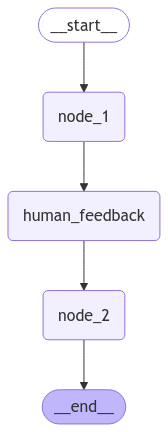

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,END,START
from langgraph.graph.state import CompiledStateGraph
from IPython.display import display,Image
from langgraph.types import interrupt ,Command
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    input:str
    user_feedback:str
    
    
def node_1(state:State):
    print("--- Node 1 ---")
    pass


def human_feedback(state:State):
    print("--- Human Feedback ---")
    feedback = interrupt("Please Provide Feedback")
    return {"user_feedback":feedback}

def node_2(state:State):
    print("--- Node 2 ---")
    pass


builder = StateGraph(State)
builder.add_node("node_1",node_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("node_2", node_2)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "human_feedback")
builder.add_edge("human_feedback", "node_2")
builder.add_edge("node_2", END)
  
memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

# graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [3]:
thread = {"configurable": {"thread_id": "2"}}
graph.invoke({"input":"Hi!"},config=thread)


--- Node 1 ---
--- Human Feedback ---


{'input': 'Hi!'}

In [4]:
result = graph.stream({"input":"Hi!"},thread,stream_mode='updates')

for i in result:
    print(i)

--- Node 1 ---
{'node_1': None}
--- Human Feedback ---
{'__interrupt__': (Interrupt(value='Please Provide Feedback', resumable=True, ns=['human_feedback:7495ede7-33ce-69d8-5a30-836a7f542c1c'], when='during'),)}


In [5]:
result = graph.astream({"input":"Hi!"},thread)

async for i in result:
    print(i)

--- Node 1 ---
{'node_1': None}
--- Human Feedback ---
{'__interrupt__': (Interrupt(value='Please Provide Feedback', resumable=True, ns=['human_feedback:15b93002-5294-47b4-3670-73aac5167541'], when='during'),)}


In [6]:
thread = {"configurable": {"thread_id": "2"}}

for event in graph.stream (Command(resume='Requesting to Start'),thread,stream_mode='updates'):
    print(event)

--- Human Feedback ---
{'human_feedback': {'user_feedback': 'Requesting to Start'}}
--- Node 2 ---
{'node_2': None}


In [ ]:
from typing_extensions import Literal

class State(TypedDict):
    input:str
    

def human_approval(state:State)->Command[Literal['call_agent','__end__']]:
    print("--- Human Approval ---")
    is_approved = interrupt("Is this correct ?")
    
    print("\n\n[RESUME AFTER INTERRUPT:]\n\n", is_approved)

    if is_approved == 'yes':
       return Command(goto='call_agent')
    else:
        return Command(goto='__end__')

def call_agent(state:State):
    print("--- Call Agent ---")
    pass

builder : StateGraph = StateGraph(State)

builder.add_node("human_approval",human_approval)
builder.add_node("call_agent", call_agent)

builder.add_edge(START, "human_approval")


graph:CompiledStateGraph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))   

In [52]:
for event in graph.stream({"input":"Hi!"},thread,stream_mode='updates'):
    print (event)

--- Human Approval ---
{'__interrupt__': (Interrupt(value='Is this correct ?', resumable=True, ns=['human_approval:4d5eb712-49db-f274-78db-659044d54a9d'], when='during'),)}


In [51]:
for event in graph.stream(Command(resume={"":""}),thread,stream_mode='updates'):
    print (event)

--- Human Approval ---


[RESUME AFTER INTERRUPT:]

 {'': ''}
{'human_approval': None}


In [53]:
for event in graph.stream(Command(resume='yes'),thread,stream_mode='updates'):
    print (event)

--- Human Approval ---


[RESUME AFTER INTERRUPT:]

 yes
{'human_approval': None}
--- Call Agent ---
{'call_agent': None}
